# Example 1: Function fitting
## SI Section 2.3: One-input two-output functional relationship
### Reference: INN paper https://www.nature.com/articles/s41467-025-63790-8

In this example, we fit a one-input two-output function described below.

\begin{gathered}
\mathbf{u}(x) = 
\begin{bmatrix}
\sin(2\pi x) \\
\exp(4x^2 - 2x - 1)
\end{bmatrix},
\quad x \in [0,1]
\end{gathered}

From this function, 10,000 randomly sampled data are generated and divided into 70% for training, 15% for validation, and 15% for testing.

The first step is to import the pyinn package.

In [2]:
from jax import config
import jax.numpy as jnp
config.update("jax_enable_x64", True)
import os, sys

# Add pyinn to path for development
sys.path.insert(0, '../pyinn')
import dataset_regression, train, plot

Set up GPUs (optional - skip if using CPU)

In [3]:
# gpu_idx = 0  # set which GPU to use
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

Next, we create the dataset and store it in /data directory. The created datafile will be named as "1D_2D_sine_exp_10000.csv"

In [4]:
# Define configuration of the dataset & training
data_name = '1D_2D_sine_exp'
config = {}
config["DATA_PARAM"] = {
    "data_name": data_name,
    "input_col": [0],
    "output_col": [1, 2],
    "bool_data_generation": True,
    "data_size": 10_000,
    "split_ratio": [0.7, 0.15, 0.15],
    "bool_normalize": True,
    "bool_shuffle": True
}
config["TRAIN_PARAM"] = {
    "num_epochs_INN": 100,
    "num_epochs_MLP": 100,
    "batch_size": 128,
    "learning_rate": 1e-3,
    "validation_period": 10,
    "patience": 10
}

# Create dataset
data = dataset_regression.Data_regression(data_name, config)

Data file data/1D_2D_sine_exp_10000.csv does not exist. Creating data...
Loaded 10000 datapoints from 1D_2D_sine_exp dataset
  Train: 7000, Val: 1500, Test: 1500


Let us visualize the data using pandas.

In [5]:
import pandas as pd

data_size = int(config["DATA_PARAM"]["data_size"])
df = pd.read_csv(f'./data/{data_name}_{data_size}.csv')
df.head()

,x1,u1,u2
0,0.850709,-0.806389,1.213376
1,0.578844,-0.475375,0.441558
2,0.176951,0.896505,0.292686
3,0.963827,-0.225330,2.199424
4,0.965970,-0.212191,2.226547


The datafile contains three columns: x1, u1, u2. This is the reason why we set the input_col = [0] and the output_col = [1,2].

Next, we define INN hyperparameters:

* **nmode**: number of tensor decomposition (TD) modes. Since the input domain is 1D, we only need nmode = 1.

* **nseg**: number of segments for each dimension. Determines the grid resolution. Here nseg = 5 (i.e., 6 grid points).

* **s_patch**: determines the number of neighboring segments for INN interpolation functions. When s_patch == 0, linear interpolation (Q=1). When s_patch > 0, nonlinear interpolation (Q=2).

* **INNactivation**: activation function for nonlinear INN. Choices: 'polynomial', 'sinusoidal', 'exponential', 'sigmoid', 'tanh', 'gelu'.

* **p_order**: number of INN activation functions to incorporate.

In [6]:
config["MODEL_PARAM"] = {
    "nmode": 1,
    "nseg": 5,
    "s_patch": 2,
    "INNactivation": "polynomial",
    "p_order": 2,
    "radial_basis": "cubicSpline",
    "alpha_dil": 20
}

Finalize the configuration.

In [7]:
if config["MODEL_PARAM"]["s_patch"] > 0:
    config['interp_method'] = "nonlinear"  # Q=2 INN
else:
    config['interp_method'] = "linear"  # Q=1 INN
config['TD_type'] = "CP"

Train INN (Q=2 nonlinear interpolation)

In [8]:
regressor = train.Regression_INN(data, config)
regressor.train()

# Access results
params = regressor.params
errors_train = regressor.errors_train
errors_val = regressor.errors_val
errors_epoch = regressor.errors_epoch
error_test = regressor.error_test

edex_max / ndex_max: 6 / 5
------------ INN CP nonlinear, nmode: 1, nseg: 5, s=2, P=2 -------------
# of training parameters: 12
Epoch 10: Train rmse=1.7395e-01, Val rmse=1.6183e-01
Epoch 20: Train rmse=3.9618e-02, Val rmse=3.6367e-02
Epoch 30: Train rmse=1.1522e-02, Val rmse=1.0934e-02
Epoch 40: Train rmse=9.4420e-03, Val rmse=9.1646e-03
Epoch 50: Train rmse=9.3857e-03, Val rmse=9.1174e-03
Epoch 60: Train rmse=9.3919e-03, Val rmse=9.1307e-03
Epoch 70: Train rmse=9.3927e-03, Val rmse=9.1179e-03
Epoch 80: Train rmse=9.3968e-03, Val rmse=9.1024e-03
Epoch 90: Train rmse=9.3902e-03, Val rmse=9.1217e-03
Epoch 100: Train rmse=9.3979e-03, Val rmse=9.1396e-03
Training completed in 1.44 seconds
Test rmse: 9.2978e-03
Inference time: 0.000000 seconds


Plot loss history

Loss plot saved to: plots\1D_2D_sine_exp_nonlinear_loss_100epoch.png


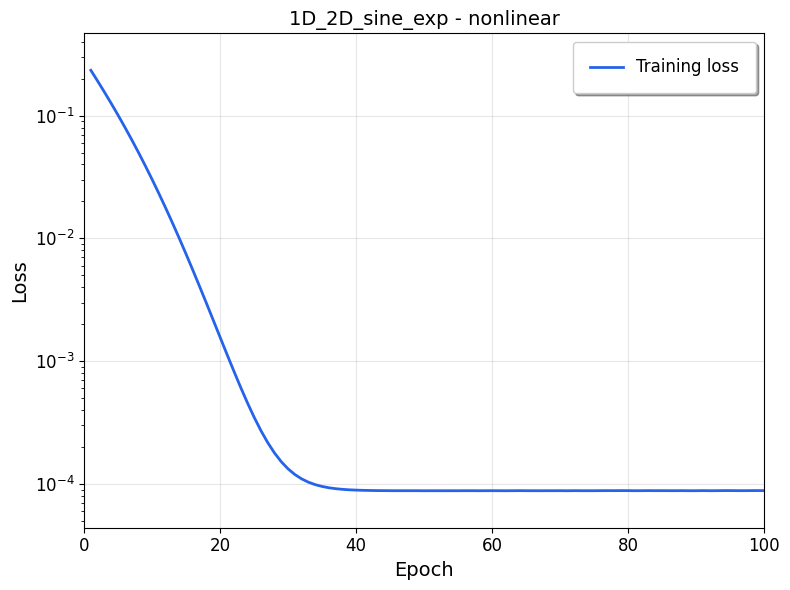

In [9]:
config["PLOT"] = {"bool_plot": True}
plot.plot_regression(regressor, data, config)